In [2]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as st
import numpy as np

In [2]:
orders = pd.read_csv("ab_orders.csv")
products = pd.read_csv("ab_products.csv")
users = pd.read_csv("ab_users_data.csv")

In [5]:
orders.head() # с колонкой product_ids придется поработать

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [6]:
orders.shape

(4123, 3)

In [7]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [8]:
products.shape

(87, 3)

In [9]:
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [10]:
users.shape #больше, чем заказов

(4337, 6)

In [11]:
users.action.unique() #два возможных события

array(['create_order', 'cancel_order'], dtype=object)

## Гипотеза 1: изменилось число заказов на пользователя

In [12]:
users.groupby("group", as_index=False).size()

,group,size
0,0,1691
1,1,2646


Так как на отменённые заказы приходится две строчки, то данные нужно немного предобработать:

In [13]:
canc_orders = users.query("action == 'cancel_order'").order_id #заказы, которые отменили
canc_orders

8        1258
39       1296
47       1298
54       1308
60       1315
        ...  
4221    54938
4255    56612
4259    56772
4307    58492
4321    59055
Name: order_id, Length: 214, dtype: int64

In [14]:
users["is_canceled"] = users["order_id"].isin(canc_orders).astype(int) #делаем переменную отмены заказа
users.head()

,user_id,order_id,action,time,date,group,is_canceled
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,0
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,1
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,0


In [15]:
users = users.query("action == 'create_order'") #отбираем только нужные строчки
users.shape

(4123, 7)

Считаем число заказов на юзера:

In [16]:
ord_per_user = users.groupby(["group", "user_id"], as_index=False).size()
ord_per_user.head()

,group,user_id,size
0,0,964,2
1,0,966,1
2,0,968,3
3,0,969,2
4,0,972,1


In [21]:
sns.set(rc={'figure.figsize':(19,14)}, style="whitegrid")

<AxesSubplot:xlabel='size', ylabel='count'>

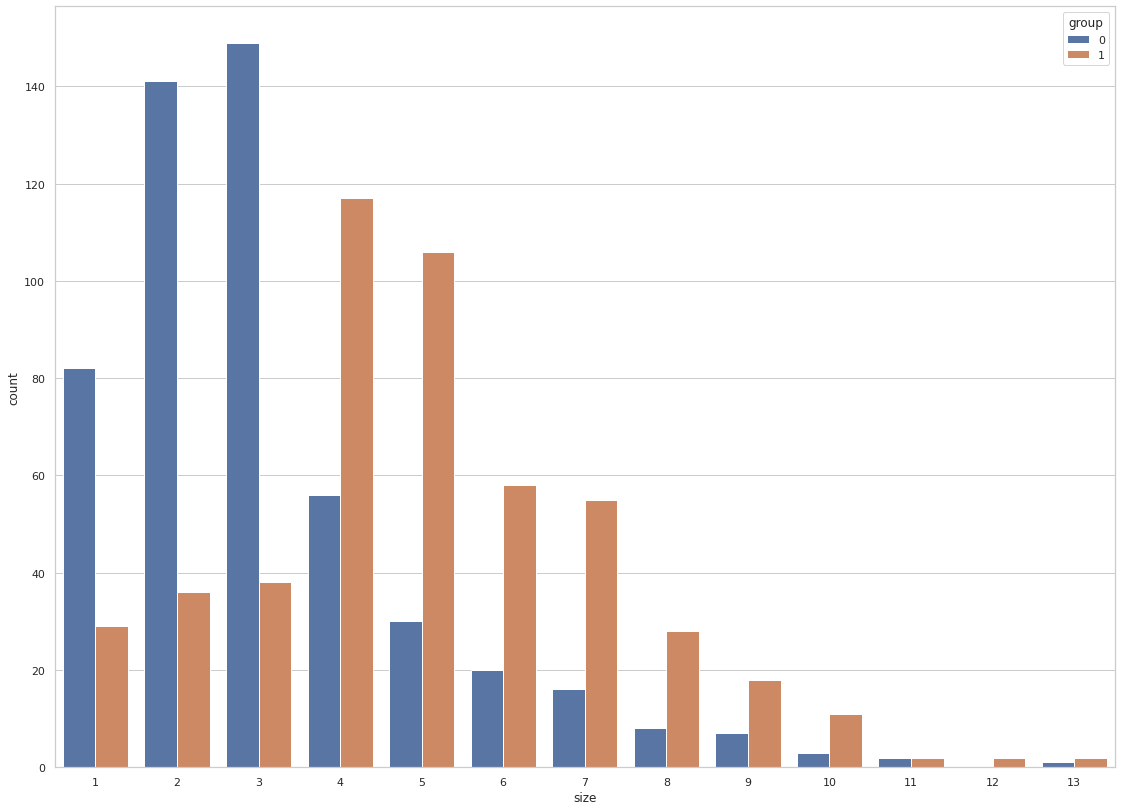

In [23]:
sns.countplot(data=ord_per_user, x="size", hue="group")

Видны различия в распределении. В нулевой группе смещение в сторону более мелкого количества заказов, а в тестовой в большую сторону. Заметна ассимтерия распределения.

In [24]:
pg.ttest(x=ord_per_user.query("group==0")["size"], 
         y=ord_per_user.query("group==1")["size"])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-14.485157,988.435475,two-sided,2.907783e-43,"[-2.14, -1.63]",0.910119,7.663e+39,1.0


Получаем статистически значимые различия в примерно 2 заказа на пользователя. 

In [25]:
pg.mwu(x=ord_per_user.query("group==0")["size"], 
         y=ord_per_user.query("group==1")["size"])

,U-val,alternative,p-val,RBC,CLES
MWU,61172.5,two-sided,6.987140e-49,0.526767,0.236617


В первой группе вероятность того, что мы возьмем случайного испытуемого и его количество заказов окажется больше количества заказов испытуемого из тестовой группы является порядка 24%. Это ощутимо меньше 50%, поэтому группы различаются, хоть и ращличия не сильно выраженные.

## Гипотеза 2: изменилась пропорция отмен

In [26]:
pd.crosstab(users.group, users.is_canceled)

is_canceled,0,1
group,,
0,1527,82
1,2382,132


На глаз не очень очевидно стало ли отмененных заказов больше в тестовой группе, то есть изменилась ли пропорция отмен в худшую сторону

In [27]:
exp, obs, stats = pg.chi2_independence(data=users, x="group", y="is_canceled")
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.021274,1.0,0.884034,0.002272,0.052441
1,cressie-read,0.666667,0.021284,1.0,0.884008,0.002272,0.052442
2,log-likelihood,0.000000,0.021304,1.0,0.883954,0.002273,0.052444
3,freeman-tukey,-0.500000,0.021319,1.0,0.883914,0.002274,0.052446
4,mod-log-likelihood,-1.000000,0.021334,1.0,0.883873,0.002275,0.052447
5,neyman,-2.000000,0.021364,1.0,0.883791,0.002276,0.052451


По тесту хи-квадрат мы можем видеть p-value>0.05  и очень маленькое значение cramer. То есть пропорция отмен не изменилась и их увеличение связано с тем, что просто количество заказов стало больше

## Гипотеза 3: изменилось число позиций в заказе

In [28]:
users.head()

,user_id,order_id,action,time,date,group,is_canceled
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,0
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,1
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,0


In [29]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [30]:
ord_content = users[["user_id", "order_id", "group"]].merge(orders) #объединим датафреймы
ord_content.head()

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,965,1256,1,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,964,1257,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,966,1258,0,2022-08-26 00:02:56.000000,"{74, 6}"
4,967,1259,1,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


Нам нужно превратить айдишники в список, после чего развернуть их:

In [31]:
ord_content["product_ids"] = ord_content.product_ids.str.strip("{}").str.split(", ")
ord_content_expl = ord_content.explode("product_ids")

In [32]:
ord_content_expl.head()

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19.000000,75
0,964,1255,0,2022-08-26 00:00:19.000000,22
0,964,1255,0,2022-08-26 00:00:19.000000,53
0,964,1255,0,2022-08-26 00:00:19.000000,84
1,965,1256,1,2022-08-26 00:02:21.000000,56


Теперь можно посчитать число позиций в заказе:

In [33]:
item_per_order = ord_content_expl.groupby(["group", "order_id"], as_index=False).size()
item_per_order.head()

,group,order_id,size
0,0,1255,4
1,0,1257,4
2,0,1258,2
3,0,1261,4
4,0,1262,4


<AxesSubplot:xlabel='size', ylabel='count'>

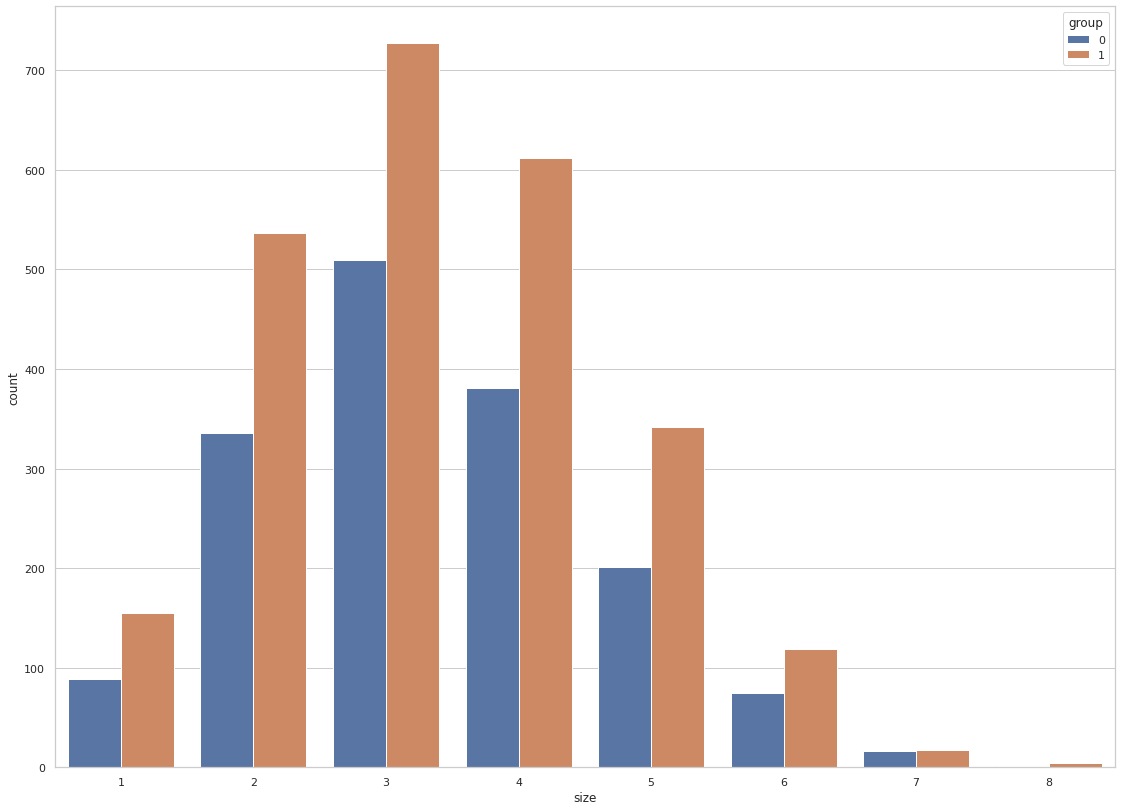

In [34]:
sns.countplot(data=item_per_order, x="size", hue="group")

Можно увидеть, что распределение заказов в группах не сильно отличаются.  Можно наблюдать, что у группы 1 столбики выше, чем у группы 0, но это может быть связано с тем, что заказов стало больше

In [35]:
pg.ttest(x=item_per_order.query("group==0")["size"], 
         y=item_per_order.query("group==1")["size"])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.138556,3469.224056,two-sided,0.889809,"[-0.09, 0.07]",0.004407,0.036,0.052185


Тест показывает, что статистически значимых различий нет

In [33]:
pg.mwu(x=item_per_order.query("group==0")["size"], 
         y=item_per_order.query("group==1")["size"])

,U-val,alternative,p-val,RBC,CLES
MWU,2013211.0,two-sided,0.79766,0.004599,0.4977


Если мы смотрим тест Манна-Уитни, то он показывает, что статистическое доминирование очень близко к 50%, то есть вероятность того, что случайный взятый человек из одной группы превысит случайно взятого человека из другой группы по количеству позиций в заказе примерно одинакова. Гипотеза не подтверждается.

## Гипотеза 4: изменилась стоимость заказа

In [36]:
ord_content_expl.head()

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19.000000,75
0,964,1255,0,2022-08-26 00:00:19.000000,22
0,964,1255,0,2022-08-26 00:00:19.000000,53
0,964,1255,0,2022-08-26 00:00:19.000000,84
1,965,1256,1,2022-08-26 00:02:21.000000,56


In [37]:
ord_content_expl.dtypes #айдишники у нас оказались строками - это надо поправить

user_id           int64
order_id          int64
group             int64
creation_time    object
product_ids      object
dtype: object

In [38]:
ord_content_expl["product_ids"] = ord_content_expl["product_ids"].astype(np.int64)

In [39]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [40]:
products.dtypes

product_id      int64
name           object
price         float64
dtype: object

In [41]:
#объединяем
ord_prices = ord_content_expl.merge(products, left_on="product_ids", right_on="product_id")
ord_prices.sort_values("order_id")

,user_id,order_id,group,creation_time,product_ids,product_id,name,price
0,964,1255,0,2022-08-26 00:00:19.000000,75,75,сок ананасовый,120.0
371,964,1255,0,2022-08-26 00:00:19.000000,84,84,мандарины,90.4
205,964,1255,0,2022-08-26 00:00:19.000000,53,53,мука,78.3
118,964,1255,0,2022-08-26 00:00:19.000000,22,22,сок мультифрукт,120.0
837,965,1256,1,2022-08-26 00:02:21.000000,76,76,чай черный в пакетиках,55.5
...,...,...,...,...,...,...,...,...
12287,1461,59487,0,2022-09-08 23:29:06.000000,9,9,чай черный листовой,83.5
12142,1461,59487,0,2022-09-08 23:29:06.000000,62,62,сок яблочный,120.0
8633,1461,59487,0,2022-09-08 23:29:06.000000,77,77,курица,298.4
8097,1376,59533,0,2022-09-08 23:41:24.000000,17,17,морс брусничный,190.0


In [42]:
value_per_order = ord_prices.groupby(["group", "order_id"], as_index=False).price.sum()
value_per_order.head()

,group,order_id,price
0,0,1255,408.7
1,0,1257,310.2
2,0,1258,85.0
3,0,1261,430.7
4,0,1262,358.6


<AxesSubplot:xlabel='price', ylabel='Count'>

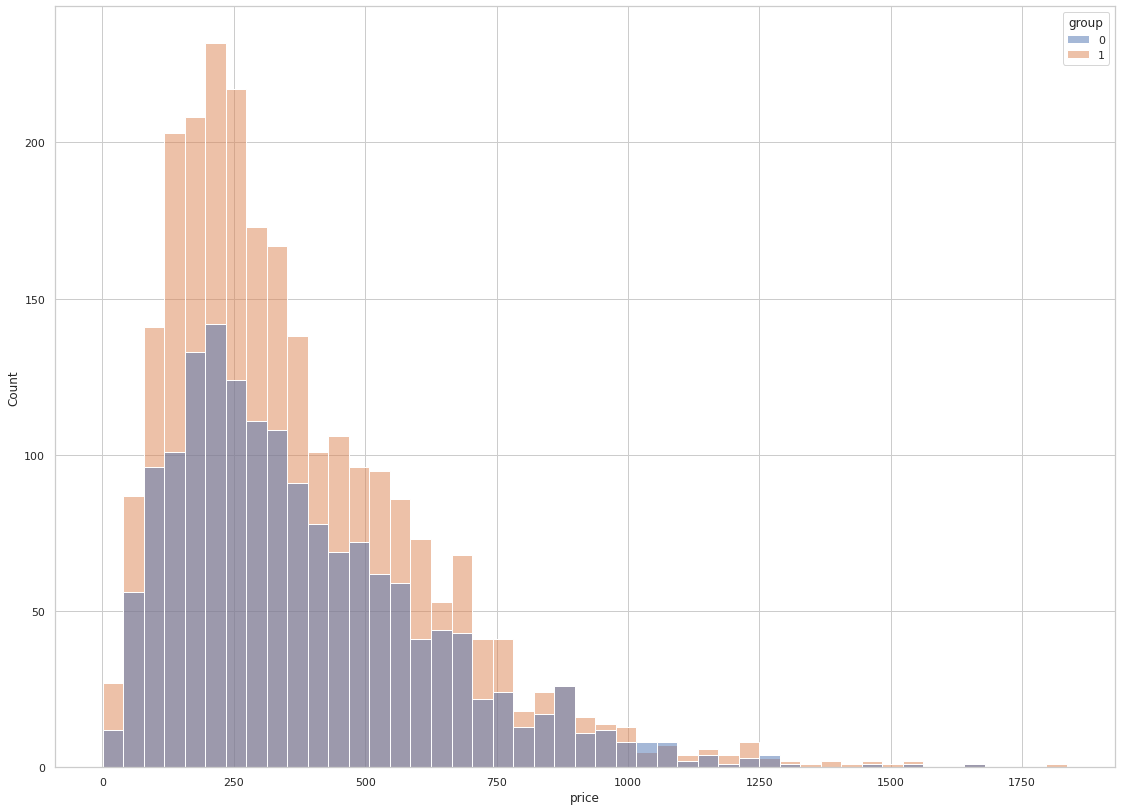

In [43]:
sns.histplot(data=value_per_order, x="price", hue="group")

Характерное ассиметричное распределение, но выраженное различие не наблюдается

In [44]:
pg.ttest(x=value_per_order.query("group==0")["price"], 
         y=value_per_order.query("group==1")["price"])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.483514,3441.720793,two-sided,0.13803,"[-3.75, 27.08]",0.047301,0.108,0.316351


Тест не показывает выраженного различия

In [43]:
pg.mwu(x=value_per_order.query("group==0")["price"], 
         y=value_per_order.query("group==1")["price"])

,U-val,alternative,p-val,RBC,CLES
MWU,2089851.0,two-sided,0.070912,-0.033294,0.516647


Тест Манна-Уитни в том числе не показывает стастически значимое доминирование

## Гипотеза 5: изменились характеристики ретеншена

In [47]:
ord_content.head()

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]"
1,965,1256,1,2022-08-26 00:02:21.000000,"[56, 76, 39]"
2,964,1257,0,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]"
3,966,1258,0,2022-08-26 00:02:56.000000,"[74, 6]"
4,967,1259,1,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]"


In [48]:
#конвертируем колонку со временем в datetime
ord_content["creation_time"] = pd.to_datetime(ord_content.creation_time)
ord_content.head()

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19,"[75, 22, 53, 84]"
1,965,1256,1,2022-08-26 00:02:21,"[56, 76, 39]"
2,964,1257,0,2022-08-26 00:02:27,"[76, 34, 41, 38]"
3,966,1258,0,2022-08-26 00:02:56,"[74, 6]"
4,967,1259,1,2022-08-26 00:03:37,"[20, 45, 67, 26]"


In [49]:
ord_content.creation_time.describe(datetime_is_numeric=True)

count                             4123
mean     2022-08-30 14:45:06.142372096
min                2022-08-26 00:00:19
25%         2022-08-26 20:14:15.500000
50%                2022-08-29 12:37:43
75%         2022-09-02 20:46:49.500000
max                2022-09-08 23:41:24
Name: creation_time, dtype: object

In [50]:
ord_content.creation_time.max() - ord_content.creation_time.min() #две недели времени

Timedelta('13 days 23:41:05')

Выявим время первого и последнего заказа:

In [51]:
retention = ord_content.groupby(["user_id", "group"], as_index=False).agg(first_order=("creation_time", "min"), 
                                                              last_order=("creation_time", "max"))
retention.head()

,user_id,group,first_order,last_order
0,964,0,2022-08-26 00:00:19,2022-08-26 00:02:27
1,965,1,2022-08-26 00:02:21,2022-09-04 22:24:32
2,966,0,2022-08-26 00:02:56,2022-08-26 00:02:56
3,967,1,2022-08-26 00:03:37,2022-08-28 16:41:30
4,968,0,2022-08-26 00:05:35,2022-08-31 05:27:34


In [52]:
(retention.last_order - retention.first_order).describe()

count                         1017
mean     6 days 23:27:21.923303834
std      4 days 06:43:22.480610835
min                0 days 00:00:00
25%                3 days 11:27:14
50%                7 days 15:39:20
75%               10 days 13:37:01
max               13 days 22:36:14
dtype: object

В среднем время между первым и последним заказом примерно неделя

Выведем "время жизни" каждого пользователя:

In [53]:
retention["lifetime"] = (retention.last_order - retention.first_order).dt.total_seconds() / (3600 * 24)
retention.head()

,user_id,group,first_order,last_order,lifetime
0,964,0,2022-08-26 00:00:19,2022-08-26 00:02:27,0.001481
1,965,1,2022-08-26 00:02:21,2022-09-04 22:24:32,9.932072
2,966,0,2022-08-26 00:02:56,2022-08-26 00:02:56,0.000000
3,967,1,2022-08-26 00:03:37,2022-08-28 16:41:30,2.692975
4,968,0,2022-08-26 00:05:35,2022-08-31 05:27:34,5.223600


In [54]:
retention.first_order.dt.date.unique() #все пользователи из одной когорты

array([datetime.date(2022, 8, 26)], dtype=object)

Когорта первого дня - 26 августа 2022

Сделаем переменную оттока. Если испытуемый не заказывал ничего в течение 7ми дней, то мы считаем его ушедшим.

In [55]:
retention["churn"] = ((ord_content.creation_time.max() - retention.last_order) > pd.Timedelta("7d")).astype(int)
retention.head()

,user_id,group,first_order,last_order,lifetime,churn
0,964,0,2022-08-26 00:00:19,2022-08-26 00:02:27,0.001481,1
1,965,1,2022-08-26 00:02:21,2022-09-04 22:24:32,9.932072,0
2,966,0,2022-08-26 00:02:56,2022-08-26 00:02:56,0.000000,1
3,967,1,2022-08-26 00:03:37,2022-08-28 16:41:30,2.692975,1
4,968,0,2022-08-26 00:05:35,2022-08-31 05:27:34,5.223600,1


<Axes: xlabel='lifetime', ylabel='Count'>

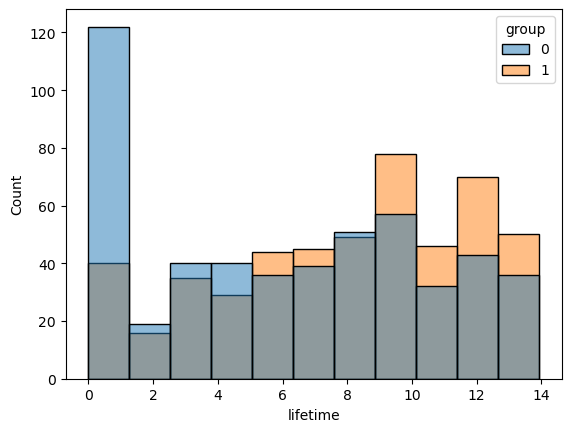

In [55]:
sns.histplot(data=retention, x="lifetime", hue="group")

В визуализации видим, что распределение примерно равномерное, только много пользователей из группы 0 ушли от нас после первого заказа

In [56]:
pg.ttest(x=retention.query("group==0")["lifetime"], 
         y=retention.query("group==1")["lifetime"])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-7.079732,1004.533039,two-sided,2.710044e-12,"[-2.37, -1.34]",0.443316,2.188e+09,1.0


Видим различия в тестах и статистически значимое p-value

In [57]:
pg.mwu(x=retention.query("group==0")["lifetime"], 
       y=retention.query("group==1")["lifetime"])

,U-val,alternative,p-val,RBC,CLES
MWU,98354.0,two-sided,3.984586e-11,0.239129,0.380436


Проанализируем с точки зрения оттока

In [58]:
pd.crosstab(retention.group, retention.churn)

churn,0,1
group,,
0,252,263
1,332,170


Можно видеть, что в 0 группе количество ушедших примерно равно количеству не покинувших нас пользователей, даже немного больше. В то время в тестовой группе больше людей остаются и меньше покидают

In [59]:
exp, obs, stat = pg.chi2_independence(data=retention, x="group", y="churn")
stat

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,30.072727,1.0,4.161428e-08,0.171959,0.999787
1,cressie-read,0.666667,30.113482,1.0,4.074885e-08,0.172076,0.999790
2,log-likelihood,0.000000,30.250438,1.0,3.797055e-08,0.172467,0.999800
3,freeman-tukey,-0.500000,30.402505,1.0,3.510745e-08,0.172900,0.999810
4,mod-log-likelihood,-1.000000,30.597845,1.0,3.174461e-08,0.173454,0.999823
5,neyman,-2.000000,31.122750,1.0,2.422158e-08,0.174936,0.999852


Хи-квадрат показывает статистически значимое различие. То есть статистически значичмо пользователи нас не покидают.

## Дополнительно: анализ выживаемости

Анализ выживаемости позволяет анализировать время до того, как случится (или не случится) событие, что делает его очень хорошим методом для анализа оттока. В этом мне поможет библиотека [lifelines](https://lifelines.readthedocs.io/en/latest/)

Будем анализировать время до оттока. Анализ того, что конкретный пользователь нас не покинет с течением времени.

In [63]:
kmf = lf.KaplanMeierFitter() #создаем модель

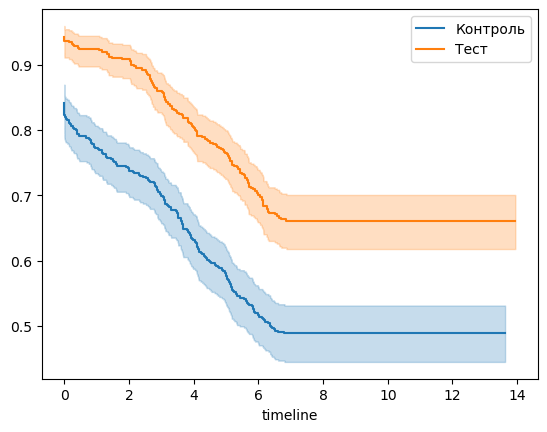

In [65]:
ax = plt.subplot(111) #чтобы поместить кривые групп на один рисунок

kmf.fit(durations=retention.query("group==0").lifetime, 
        event_observed=retention.query("group==0").churn,
        label="Контроль") #строим модель
kmf.plot(ax=ax) #рисуем

kmf.fit(durations=retention.query("group==1").lifetime, 
        event_observed=retention.query("group==1").churn,
        label="Тест")
kmf.plot(ax=ax)

plt.show()

Выход на плато в райное 7ми дней из-за критерия churn в 7 дней. Анализ выживаемости показывает, как кривые находятся явно далеко друг от друга и вероятность того, что в тесте с нами останется конкретный пользователь с течением времени ощутимо выше в тесте, чем в контроле. 

Оценю результат статистически:

In [66]:
lf.statistics.logrank_test(durations_A=retention.query("group==0").lifetime, 
                           durations_B=retention.query("group==1").lifetime, 
                           event_observed_A=retention.query("group==0").churn,
                           event_observed_B=retention.query("group==1").churn)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          37.41 <0.005     29.96

Наблюдается статистически значимое различие. -log2(p) показывает, что очень маловероятна верность нулевой гипотезы. 